# **Machine learning - final project**
## **Clinical Data**

**Names and IDs:**

1.   Natalie Morad
2.   Stav Nimrod

## Assignment:

In this exercise, you are given (a part of) a data set from a clinical trial. You will need to use 3 types of prediction models and compare between.
The first model should be a linear classifier.
The second one should be an ensemble model.
The third should be a DL one.

**imports here**

In [ ]:
# libs
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# metrics
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.metrics import Recall, Precision, AUC

# models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

## **Loading the data**

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ex4_data.csv to ex4_data.csv
User uploaded file "ex4_data.csv" with length 1546386 bytes


In [ ]:
df = pd.read_csv('/content/ex4_data.csv')

In [ ]:
df.head()

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,RACE_BLACK,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,False,60,False,True,True,False,False,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,False,75,False,False,False,False,True,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,False,62,False,False,False,False,False,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,False,75,True,False,False,False,True,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,False,81,False,False,False,False,True,WHITE,126,108,39,84,28.78,36.660286,False,1,False


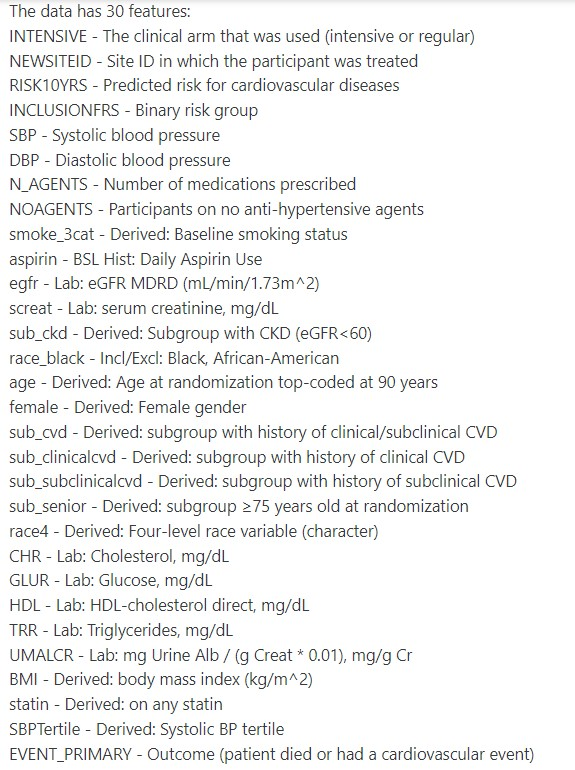

## **Preprocessing**

### Data Cleaning

In [ ]:
df.isna().sum()

INTENSIVE               0
NEWSITEID             465
RISK10YRS               0
INCLUSIONFRS            0
SBP                     0
DBP                     0
N_AGENTS                0
NOAGENTS                0
SMOKE_3CAT              0
ASPIRIN                 0
EGFR                    0
SCREAT                  0
SUB_CKD                 0
RACE_BLACK              0
AGE                     0
FEMALE                  0
SUB_CVD                 0
SUB_CLINICALCVD         0
SUB_SUBCLINICALCVD      0
SUB_SENIOR              0
RACE4                   0
CHR                     0
GLUR                    0
HDL                     0
TRR                     0
UMALCR                  0
BMI                     0
STATIN                  0
SBPTERTILE              0
EVENT_PRIMARY           0
dtype: int64

We can see that there are 465 missing values at "*NEWSITEID - Site ID in which the participant was treated*", since replacing nulls with mean value of ID's would be meaningless, we decided to set them to 0 and not to drop these rows so that the models can learn it as a category

In [ ]:
df["NEWSITEID"].fillna(0, inplace = True)

**Columns type check:**

In [ ]:
df.dtypes

INTENSIVE              object
NEWSITEID             float64
RISK10YRS             float64
INCLUSIONFRS             bool
SBP                     int64
DBP                     int64
N_AGENTS                int64
NOAGENTS                 bool
SMOKE_3CAT              int64
ASPIRIN                  bool
EGFR                  float64
SCREAT                float64
SUB_CKD                  bool
RACE_BLACK               bool
AGE                     int64
FEMALE                   bool
SUB_CVD                  bool
SUB_CLINICALCVD          bool
SUB_SUBCLINICALCVD       bool
SUB_SENIOR               bool
RACE4                  object
CHR                     int64
GLUR                    int64
HDL                     int64
TRR                     int64
UMALCR                float64
BMI                   float64
STATIN                   bool
SBPTERTILE              int64
EVENT_PRIMARY            bool
dtype: object

We can see that *'INTENSIVE'* and *'RACE4'* columns type is object, and column 'NEWSITEID' is currently numerical, thus we will change them to categorial

In [ ]:
df['RACE4'] = df['RACE4'].astype("category")
df['INTENSIVE'] = df['INTENSIVE'].astype("category")
df['NEWSITEID'] = df['NEWSITEID'].astype("category")

### Splitting the data

Target label counts:

In [ ]:
df['EVENT_PRIMARY'].value_counts()

False    8207
True      539
Name: EVENT_PRIMARY, dtype: int64

As we can see there are alot less *True* records in the data set, therefore we want to keep this ratio for train/test sets using stratify:

In [ ]:
X = df.iloc[:, :-1]
y = df['EVENT_PRIMARY']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

### Scaling the data

We will fit scalers on train set only, then transforming test set accordingly, this way we will not cause data leakage between train and test sets.

Numerical features- preprocessed by fitting a SimpleImputer so production model will be able to deal with missing numeric values, next we fit StandardScaler.
Categorial features- 1-C dummie variables using OneHotEncoder.

In [ ]:
# numeric scaler
numeric_features = df.select_dtypes(exclude=['category', 'bool']).columns.tolist()
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

# categorial scaler
categorical_features = df.select_dtypes('category').columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)


# append scalers
preprocessor = ColumnTransformer(
                transformers=[
                  ("numerical", numeric_transformer, numeric_features),
                  ("category", categorical_transformer, categorical_features)])

# create column scaler pipeline
scaler_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
)


scaler_pipeline.fit(X_train)
set_config(display="diagram")
scaler_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RISK10YRS', 'SBP', 'DBP',
                                                   'N_AGENTS', 'SMOKE_3CAT',
                                                   'EGFR', 'SCREAT', 'AGE',
                                                   'CHR', 'GLUR', 'HDL', 'TRR',
                                                   'UMALCR', 'BMI',
                                                   'SBPTERTILE']),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['INTENSIVE', 'NEWSITEID',
                                                   'RACE4'])]))])

In [ ]:
X_train = scaler_pipeline.transform(X_train)
X_test = scaler_pipeline.transform(X_test)

## **Training Models**

### Model 1

**Linear Classifier - Logistic Regression**

In [ ]:
lr = LogisticRegression()

# Choose some parameter combinations to try
parameters = {'class_weight': ['balanced'],
              'max_iter':[20, 50, 100, 500] ,
              'penalty': ['l2'],
              'solver': ['lbfgs', 'liblinear'],
              'C':[0.001,0.01]
              }

# Define scorer
scorer = make_scorer(roc_auc_score)

# Run the grid search
grid_obj = GridSearchCV(estimator = lr, 
                        param_grid = parameters,
                        scoring = scorer,
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
lr_cv_scores = pd.DataFrame(grid_obj.cv_results_)
lr_cv_auc_score = max(lr_cv_scores['mean_test_score'])

clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

lr_auc_test_score = roc_auc_score(y_test, y_pred)
lr_recall_test_score = recall_score(y_test, y_pred)
lr_precision_test_score = precision_score(y_test, y_pred)
lr_accuracy_test_score = accuracy_score(y_test, y_pred)

print('-'*20)
print('Model 1 results: \n')
print('CV-5 AUC: %.5f' % lr_cv_auc_score)
print('Test AUC: %.5f' % lr_auc_test_score)
print('-'*20)

--------------------
Model 1 results: 

CV-5 AUC: 0.62908
Test AUC: 0.61091
--------------------


### Model 2

**Ensemble Model - Random Forest**

In [ ]:
rf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [3, 4, 5],
              'max_features': ['log2', 'auto'], 
              'criterion': ['entropy'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8],
              'class_weight': ['balanced'],
              'n_jobs': [-1]
             }
# Define scorer
scorer = make_scorer(roc_auc_score)

# Run the grid search
grid_obj = GridSearchCV(estimator = rf, 
                        param_grid = parameters,
                        scoring = scorer,
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
rf_cv_scores = pd.DataFrame(grid_obj.cv_results_)
rf_cv_auc_score = max(rf_cv_scores['mean_test_score'])

clf2 = grid_obj.best_estimator_
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)

rf_auc_test_score = roc_auc_score(y_test, y_pred2)
rf_recall_test_score = recall_score(y_test, y_pred2)
rf_precision_test_score = precision_score(y_test, y_pred2)
rf_accuracy_test_score = accuracy_score(y_test, y_pred2)

print('-'*20)
print('Model 2 results: \n')
print('CV-5 AUC: %.5f' % rf_cv_auc_score)
print('Test AUC: %.5f' % rf_auc_test_score)
print('-'*20)

--------------------
Model 2 results: 

CV-5 AUC: 0.61244
Test AUC: 0.58156
--------------------


### Model 3

**Deep Learning Model - Neural Network**

In [ ]:
# preprocessing nn model output(size 2)
y_train_dl = to_categorical(y_train)
y_test_dl = to_categorical(y_test)

In [ ]:
tf.keras.backend.clear_session()

# define stopping criterion
stopping = EarlyStopping(monitor='val_auc', patience=5)

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=104, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall(), Precision(), AUC(), 'accuracy'])

# fit the keras model on the dataset
history = model.fit(x=X_train, y=y_train_dl, batch_size=512, epochs=30, validation_split=0.2, callbacks=stopping, workers=-1)

Epoch 1/30
11/11 [==============================] - 2s 61ms/step - loss: 0.6862 - recall: 0.5436 - precision: 0.5437 - auc: 0.5854 - accuracy: 0.5438 - val_loss: 0.6622 - val_recall: 0.7686 - val_precision: 0.7686 - val_auc: 0.8405 - val_accuracy: 0.7686
Epoch 2/30
11/11 [==============================] - 0s 6ms/step - loss: 0.6497 - recall: 0.7802 - precision: 0.7802 - auc: 0.8509 - accuracy: 0.7802 - val_loss: 0.6229 - val_recall: 0.9121 - val_precision: 0.9121 - val_auc: 0.9200 - val_accuracy: 0.9121
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 0.6113 - recall: 0.8956 - precision: 0.8956 - auc: 0.9230 - accuracy: 0.8956 - val_loss: 0.5805 - val_recall: 0.9336 - val_precision: 0.9336 - val_auc: 0.9228 - val_accuracy: 0.9336
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 0.5687 - recall: 0.9274 - precision: 0.9274 - auc: 0.9298 - accuracy: 0.9274 - val_loss: 0.5324 - val_recall: 0.9336 - val_precision: 0.9336 - val_auc: 0.9238 - val_

Plot NN model progression and finetune parameters accordingly:

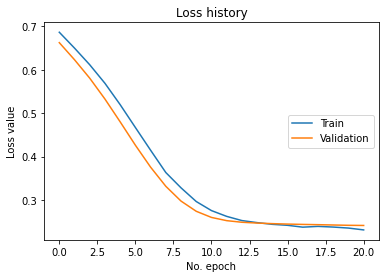

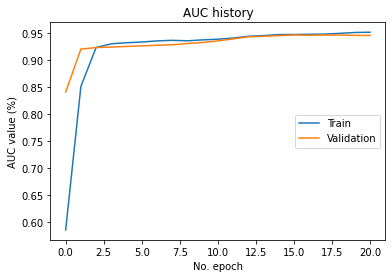

In [ ]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['Train', 'Validation'], loc='right')
plt.show()

# Plot history: AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC history')
plt.ylabel('AUC value (%)')
plt.xlabel('No. epoch')
plt.legend(['Train', 'Validation'], loc='right')
plt.show()

In [ ]:
nn_cv_auc_score = max(history.history['val_auc'])
loss, nn_recall_test_score, nn_precision_test_score, nn_auc_test_score, nn_accuracy_test_score = model.evaluate(X_test, y_test_dl, verbose=False)

print('-'*20)
print('Model 3 results: \n')
print('CV-5 AUC: %.5f' % nn_cv_auc_score)
print('Test AUC: %.5f' % nn_auc_test_score)
print('-'*20)

--------------------
Model 3 results: 

CV-5 AUC: 0.94613
Test AUC: 0.94778
--------------------


## **Models Comparison**

The metric we used to measure the models preformence is AUC, because it composed of Recall(sensitivity) and FNR(1-specificity).
The reason we care about these metrics is because for this specific task(clinical trail - heart failure) missing a patient with a heart failure can lead to serious health issuses. Moreover, predicting an healthy patient as sick might make him go through unnecessary tests, prolong the queues in the hospital, etc.

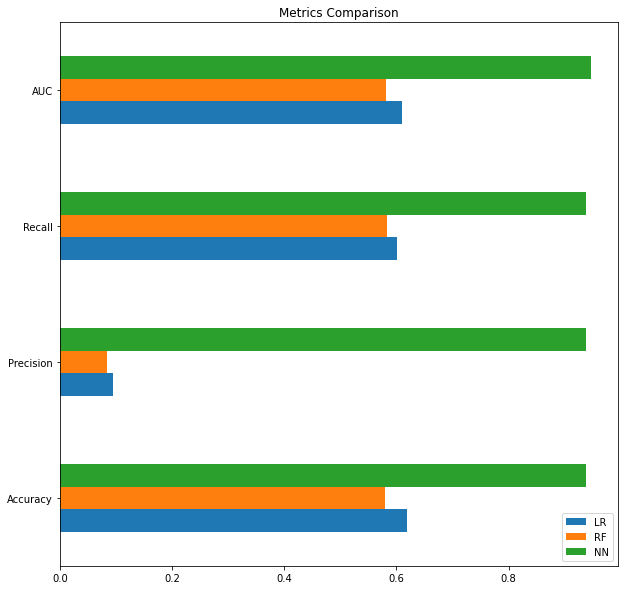

In [ ]:
lr_scores = [lr_accuracy_test_score, lr_precision_test_score, lr_recall_test_score, lr_auc_test_score]
rf_scores = [rf_accuracy_test_score, rf_precision_test_score, rf_recall_test_score, rf_auc_test_score]
nn_scores = [nn_accuracy_test_score, nn_precision_test_score, nn_recall_test_score, nn_auc_test_score]
index = ['Accuracy', 'Precision', 'Recall', 'AUC']
metrics_comparasion = pd.DataFrame({'LR': lr_scores, 'RF': rf_scores, 'NN': nn_scores}, index=index)
ax = metrics_comparasion.plot.barh(figsize=(10, 10), title='Metrics Comparison')

Model3(NN) presents the best preformence overall and we can see that his AUC is the highest.

We can check for overfitting with AUC score as we saw in class. AUC of train should be similar to test so we can decide there is no overfit.
* Note that the models were overfitting at the first attempts but we fixed them. 

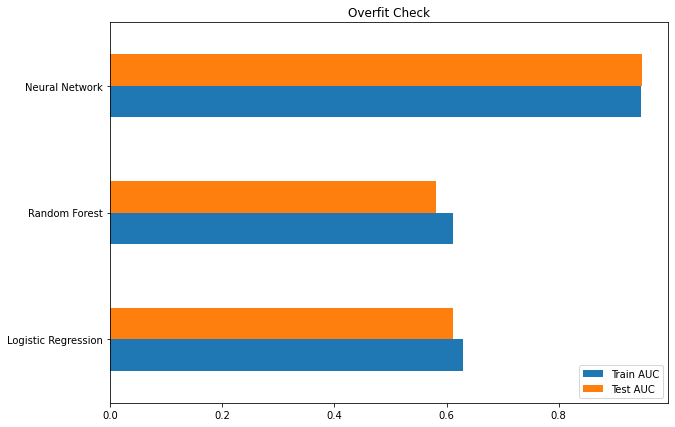

In [ ]:
train = [lr_cv_auc_score, rf_cv_auc_score, nn_cv_auc_score]
test = [lr_auc_test_score, rf_auc_test_score, nn_auc_test_score]
index = ['Logistic Regression', 'Random Forest', 'Neural Network']
auc_overfit_check = pd.DataFrame({'Train AUC': train, 'Test AUC': test}, index=index)
ax = auc_overfit_check.plot.barh(figsize=(10, 7), title='Overfit Check')

We can see that all 3 models are not overfitted now and model3(NN) has highest AUC for training(cross-validation) as well as for testing.

## **Answer the next questions**

Questions:

1. For each model, does the model overfit?
2. In the DL model, what's the effect of batch size in general, and do you see this effect in the current task?

Answers:

**1.** 
* Logistic regression - no over fit, grid search helped us to find the right parameters.
* Random forest - no over fit, this model tends to overfit, it took alot of tuning, we noticed that when n_estimators is high, the model is fitting too strict to the training set, thus it had good results on training set but couldn't generalize well and did poor on testing.
* Neural Network - no over fit, at first attemps it did overfit, we added validation split and monitored the AUC score with earlystopping function, we then plotted the model progress to check for overfitting and for fine-tuning.

**2.** 
* The effect of the batch size has is that small batch results generally in rapid learning but a volatile learning process with higher variance in the classification accuracy. Larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model exemplified by lower variance in classification accuracy. (https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)
* Yes we saw this effect in this task when we were fine-tuning the model parameters.

## **Additional details**

*Notice: You need to well explain why you choose the specific algorithms, configurations, or other decisions you made. In the end, briefly summarize the method and details.*

* In order to avoid data leakage from the test set, we made a pipeline that scales each column as we wish. For numerical columns we used SimpleImputer to handle missing data and on top of it we used StandardScaler, for categorial columns we used OneHotEncoder(dummie-coding). The pipeline is first fitted to the training set, then the pipeline transforms train and test sets.

* Model 1 - We chose logistic regression model,
because it can make binary classification, we also tried SVM(for classification) but noticed that logistic regression preforms better, we used grid search to find the best parameters for our scaled data.
* Model 2 - We chose Random Forest model,
because it can make binary classification, we also tried Adaboost(with classification trees) but noticed that Random forest preforms better, we used grid search to find the best parameters for our scaled data, we also noticed that for high n_estimators this model tend to overfit, thus we kept n_estimators low.
* Model 3 - We chose Neural Network model,
we adjusted the output layer so the model can make binary classification, we also tried MLP Classifier(from scikit-learn) but noticed that keras is more adjustable thus preforms better, we used earlystopping and plots to find the best parameters for our scaled data, we also noticed the effect batch size has, added dropout layer to help the model generalize and avoid overfitting.